<a href="https://colab.research.google.com/github/philliewright/toxic_comments_neural_nets/blob/main/Final_NN_CW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Networks Coursework 1

## Toxic Comment Classification

## Introduction


In the modern, internet driven world, the threat landscape seen in online comments has grown increasingly worrysome and harmful. Polarisation in thinking is increasing and online harrassment for peoples opinions, beliefs and facets of their identity is a huge problem. These comments which can be harmful, offensive and disruptive can have sever impacts on the individuals and communities. We must tackle this problem in order to preserve the integrity and inclusivity of online spaces, in the form of content moderation.

We are looking to help takle this problem by using Neural Networks to find and classify toxic comments of different types. Neural Netwroks have the ability to process and learn from huge datasets of text and will be a promising place to come at a solution from. We will be using multilabel classification to attempt to label the comments as either Toxic, Severely Toxic, Obscene, Threat, Insult and Identity hate. We hope this model will be a good start for a tool to maintain healthy online interactions.

The origional source of the data is a collection of comments from Wikipedia's talk page edits. The dataset is the Toxic Comment Classification dataset from Kaggle, obtained using the following link:
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
Given the extensive nature of the dataset we feel it is a realistic cross section of the challenges which we'd expect to encouner in moderating real time online discussions.

We are going to follow the methodical approach of Francois Chollet's universal workflow of Deep Learning which we detail below.[1] We want to build a functional model but also fully understand the details of how the neural networks work in the context of NLP.

## Method

We will be using Chollets universal workflow of Deep Learning as defined in 'Deep Learning with Python' which is a structured approach to developing deep learning models.

A summary of this workflow is given below:
### 1. Define the Problem and Assemble a Dataset
- **Understand the Problem**: We will outline what we are trying to achieve. This includes understanding the problem's nature (classification, regression, etc.) and its complexity. For this project, we are making a classification model.
- **Collect a Dataset**: This step is to identify and gather the data we need and amke sure it's representative of the problem we are trying to solve.

### 2. Choose a Measure of Success
- **Select an Evaluation Protocol and Loss Function**: We have decided to use accuracy, precision, recall and F1 score. We will use the binary cross entropy a loss function, which our model will seek to minimize.

### 3. Determine the Evaluation Protocol
- **Choose How to Evaluate the Model**: We will use k-fold cross-validation to further evaluate our model.

### 4. Prepare Your Data
- **Data Preprocessing**: Format the data (normalization, vectorization, etc.) so that it can be fed into a neural network. This step includes splitting the data into training, validation, and test sets.

### 5. Develop a Baseline Model
- **Build a Small Model**: Start with a simple model (logistic regression) that can process the data and provide a baseline performance. This will mean we can have a point of comparison for more complex models later. We have decided to use a simple Logistic regression as our baseline model.

### 6. Scale Up: Develop a Model That Overfits
- **Build a Larger Model**: Once we have a baseline, we will build a more complex model capable of overfitting. This step is so that we push the limits to understand the capacity needed to solve the problem.

### 7. Regularize and Tune Your Model
- **Fight Overfitting**: Use techniques like dropout, regularisation, or feature reduction to mitigate overfitting.
- **Hyperparameter Tuning**: Adjust learning rates, batch sizes, number of layers/neurons, etc., to find the best performing model configuration.

### 8. Iterate on Your Model
- **Refine the Model**: Based on the performance of the model, we will go back and make adjustments. This might include gathering more data, adjusting hyperparameters, or changing the architecture.

### 9. Evaluate the Final Model
- **Test the Model**: Once the model performs well on the validation data, evaluate it on the test data to estimate how it will perform in the real world.


In [1]:
# necessary instillations
! pip install tensorflow
!pip install scikeras
!pip install tensorflow-addons
!pip install --upgrade tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 2.9 MB/s eta 0:00:00


In [2]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [3]:
! pip install --upgrade mlflow


In [4]:
# necessary imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.metrics as tf_metrics
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from imblearn.over_sampling import RandomOverSampler
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scikeras.wrappers import KerasClassifier
from scipy.sparse import vstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras

# Download necessary NLTK packages
download('punkt')
download('stopwords')
download('wordnet')


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# 1. Define the Problem and Assemble a Dataset

The problem we are trying to solve is - what configuration of a Neural Network can best be used to classify toxic comments online in order to better understand the threat landscape and potentially contribute to mitigating these threats. To do this we will be using classification techniques and Dense and Dropout layers in our Neural Network.

In [5]:
# Mounting the GDrive
drive.mount('/content/drive')

# Path to folder in GDrive
folder_path = '/content/drive/MyDrive/Projects_Portfolio/toxic_comment_neural_nets'



Mounted at /content/drive


In [6]:
# listing all files in the folder to check its correct
all_files = os.listdir(folder_path)
all_files


['train.csv', 'test.csv', 'test_labels.csv', 'Final_NN_CW1.ipynb']

In [7]:
# constructing the file paths
train_file_path = os.path.join(folder_path, 'train.csv')
test_file_path = os.path.join(folder_path, 'test.csv')
test_labels_file_path = os.path.join(folder_path, 'test_labels.csv')


# Reading in the CSV files
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)
test_labels = pd.read_csv(test_labels_file_path)


In [8]:
#train_data.head()
#test_data.head()
test_labels.head()

# Removing rows where any label is -1 as there was some contamination in the data, but only a small amount
valid_test_labels = test_labels[(test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] != -1).all(axis=1)]
y_test_filtered = valid_test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]


#print("\nUnique Values for 'column_name':\n", unique_values)
y_test_filtered.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0,0,0,0,0,0
7,0,0,0,0,0,0
11,0,0,0,0,0,0
13,0,0,0,0,0,0
14,0,0,0,0,0,0


In [9]:
# Add 'id' column to y_test_filtered for when we merge it
y_test_filtered['id'] = valid_test_labels['id']

# Merge test_data with y_test_filtered based on 'id'
merged_test_data = pd.merge(test_data, y_test_filtered, on='id')

# making new aligned X_test and y_test
X_test_aligned = merged_test_data['comment_text']
y_test_aligned = merged_test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]


In [10]:
# extracting training and test data
X_train = train_data['comment_text']
y_train = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
X_test = X_test_aligned
y_test = y_test_aligned[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [11]:
# Counting the number of rows in X_train and X_test
num_rows_X_train = X_train.shape[0]
num_rows_X_test = X_test.shape[0]

# Print the counts
print("Number of rows in X_train:", num_rows_X_train)
print("Number of rows in X_test:", num_rows_X_test)


Number of rows in X_train: 159571
Number of rows in X_test: 63978


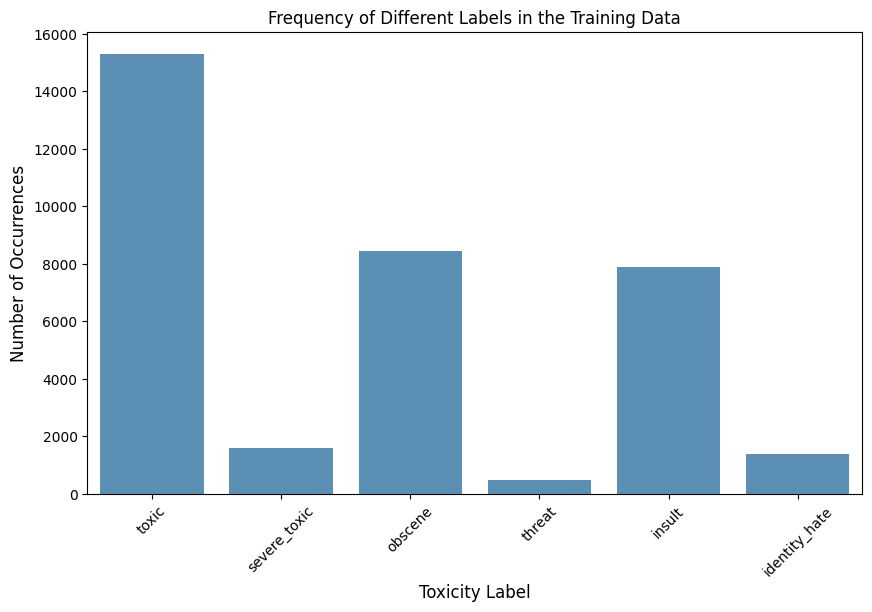

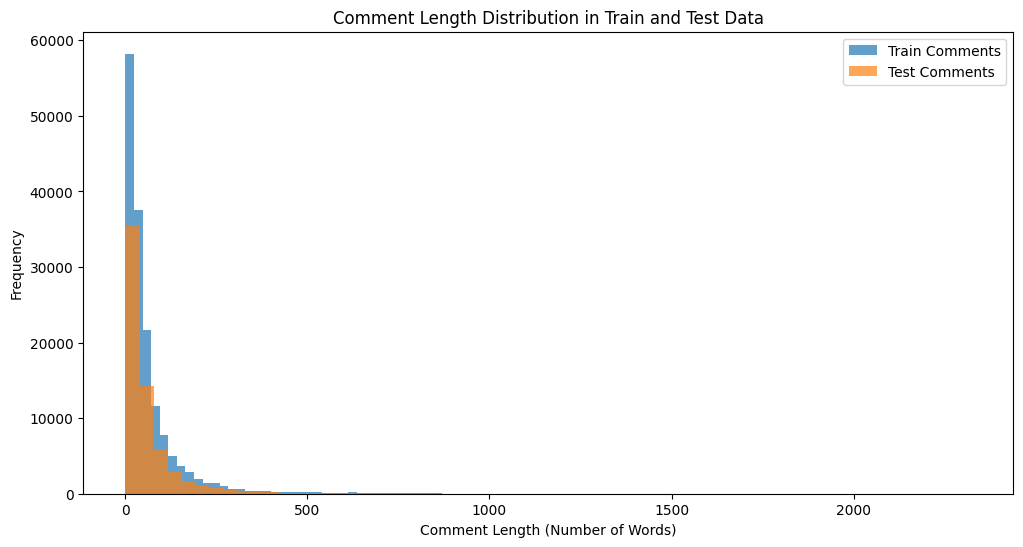

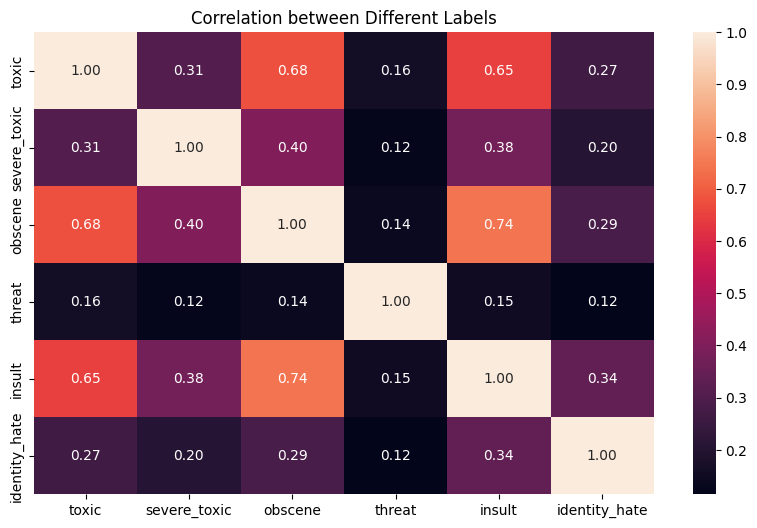

In [12]:
# descriptive stats of the dataset:

# distribution of different toxicity labels
label_counts = y_train.sum()
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8)
plt.title('Frequency of Different Labels in the Training Data')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Toxicity Label', fontsize=12)
plt.xticks(rotation=45)
plt.show()


# length of comments in the training and test sets
train_comment_lengths = X_train.apply(lambda x: len(x.split()))
test_comment_lengths = X_test.apply(lambda x: len(x.split()))

# comment distributiion by lenght
plt.figure(figsize=(12,6))
plt.hist(train_comment_lengths, bins=60, alpha=0.7, label='Train Comments')
plt.hist(test_comment_lengths, bins=60, alpha=0.7, label='Test Comments')
plt.title('Comment Length Distribution in Train and Test Data')
plt.xlabel('Comment Length (Number of Words)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# heatmap of the labels correlation
plt.figure(figsize=(10,6))
sns.heatmap(y_train.corr(), annot=True, fmt=".2f")
plt.title('Correlation between Different Labels')
plt.show()


We can see that 'toxic' has by far the most number of comments labelled. We can also see there is a huge amount of imbalence so try to correct. The distribution of lengths of comments seem similar for Test and Train data which is good as it suggests the model will be trained on representative data in terms of comment length.

The heatmap shows a very high correlation between 'obscene' and 'insult' comments as well as 'insult' and 'toxic' which means many comments that are labelled one are also labelled the other. It is interesting that 'threat' has low corellations with all of the other labels, suggesting not much of a crossover. This could be because there are unique charachteristics of 'threat' comments which may require special consideration in the modelling

# 2. Choosing a measure of success

For this model we will be evaluating accuracy, precision, recall and F1 score. In our case accuracy may not be the most informative metric as it can often be skewed to the majority class. F1 is especially cruicial for imbalenced datasets as it measures the balence between precision and recall. In our case, missing a toxic comment and having lower recall may be more problematic than classifying non toxic comments as toxic.

We will also be using the binary cross entropy a loss function, which our model will try to minimise. Binary cross entropy will calculate the loss for each of the classes and aggregate these to penalise the incorrect classifications.

We will also experiment with including the Receiver Operating Characteristic - Area Under Curve (ROC-AUC) score. This metric is particularly good in imbalanced datasets as it evaluates the model's ability to distinguish between classes across different threasholds, providing a measure of performance unaffected by class imbalance.

Given the imbalances in our dataset, we will explore incorporating class weights in our loss function. This approach will help in adjusting the model's sensitivity to underrepresented classes so that we have a balanced performance across all categories of toxicity.

We hope that measuring all of these as they will give a well rounded idea of how the model is performing. Binary cross entropy is a good loss function when dealing with multilabel classification as it calculates the loss for each class and then sums them up. This allows the model to penalise incorrect classifications effectively.




# 3. Determining how to Evaluate the Model

Once we have a model which seems to perform well, we will impletment k-fold cross-validation to evaluate our model. It will help in assessing how the model's performance will generalise to an independent dataset and mitigates the risk of overfitting to the training data. We will then of course test it on unseen test data as a final evaluation of performance comparing two models for their performance on the unseen test data.

### 3.1 Adding MLFLow


In [13]:
mlflow.set_experiment("Toxic Comment Classification")



2024/01/20 14:53:08 INFO mlflow.tracking.fluent: Experiment with name 'Toxic Comment Classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/337143090584941580', creation_time=1705762388789, experiment_id='337143090584941580', last_update_time=1705762388789, lifecycle_stage='active', name='Toxic Comment Classification', tags={}>

# 4. Preparing the data

To effectively prepare the data for training we will complete the following steps:


1.   Remove Stop words from the text - this reduces the size of the data for efficiency as well as taking away words which are likely to not contribute to context.
2.   Tokenise - this splits the text into words (tokens). This is an important step in getting unstructred text into a structured form.
3.   Lemmatise - This is grouping together different inflected forms of the same words and reducing them to their root form.It helps to consolidate different forms of a word into a single entity.
4. Vectorisation - This is needed to convert the text into numerical vectors. We will be using TF-IDF  (Term Frequency-Inverse Document Frequency)  vectorisation using 500 features. There is a risk that only using 500 features will miss some nuances of that data. However it will be more efficient and reduce computational load.



### Removing Stopwords and Tokenising

In [14]:
# Seting English stopwords
stop_words = set(stopwords.words('english'))

# tokenise the comments and remove stopwords
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stop_words]

# applying the tokenisation and stopword removal to training and test data
X_train_tokens = X_train.apply(tokenize_and_remove_stopwords)
X_test_tokens = X_test.apply(tokenize_and_remove_stopwords)


### Lemmatising

In [15]:
# initialise lemmatizer
lemmatizer = WordNetLemmatizer()

# lemmatise
def lemmatize_tokens(tokens):
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

# Apply lemmatization to tokenized data
X_train_preprocessed = X_train_tokens.apply(lemmatize_tokens)
X_test_preprocessed = X_test_tokens.apply(lemmatize_tokens)


### Vectorising

For our vectorising we will be using TF-IDF Vectorisation. TF-IDF stands for Term Frequency-Inverse Document Frequency which is a measurement used to show how important a word is in any document or collection, here the comments. It is used in vectorisation to transform data into numerical vecors so that a machine lerning algorithm can learn, predict and classify from it. As most terms will not appear in all comments, the resulting matrix will be very sparse. We will not convert the matrix into a dense array due to computational resource constraints and this is a highly memory intensive process. When needed we can convert the matrix in batches for training.


In [16]:
# TF-IDF Vectorization (Keepinf as sparse matrix, will make desnse in generator)
tfidf_vectorizer = TfidfVectorizer(max_features=500)
X_train_tfidf_sparse = tfidf_vectorizer.fit_transform(X_train_preprocessed)
X_test_tfidf_sparse = tfidf_vectorizer.transform(X_test_preprocessed)#

### Conducting some exploratory analyis to ensure the vectorisation is succesful and looking at the distribution of labels

In [17]:
# how many comments
num_samples = X_train_tfidf_sparse.shape[0]
print(f"Number of samples in training data: {num_samples}")

# cgeck number of features after vectorising
num_features = X_train_tfidf_sparse.shape[1]
print(f"Number of features (after TF-IDF): {num_features}")

# checking the sparsity of the matrix - expecting very sparse
non_zero_elements = X_train_tfidf_sparse.nnz
total_elements = X_train_tfidf_sparse.shape[0] * X_train_tfidf_sparse.shape[1]
sparsity = (1.0 - non_zero_elements / float(total_elements))

print(f"Sparsity of the TF-IDF matrix: {sparsity:.2%}")

# distribution of Labels
label_counts = y_train.sum().sort_values(ascending=False)
print("Label distribution:\n", label_counts)



Number of samples in training data: 159571
Number of features (after TF-IDF): 500
Sparsity of the TF-IDF matrix: 97.15%
Label distribution:
 toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


The above results show that the dataset has 159571 comments to train the data from. The TF-IDF has vectorised using 500 features as we specified in the vectorisation to limit the TF-IDF to ensure the dataset was not too large for efficiency. Therefore only the top 500 most common words will be analysed.

The sparsity of 97.15% is expected as most words wont appear in all the comments.

The distribution in the labels shows threat to be the least common label and toxic to be the most. There is a class imbalence here which is a challenge we will address within out Neural Network.

# 5. Develop a Baseline Model

In order to evaluate how well the model the models perform and ensure the data has been processed effectively, it is good to establish a baseline model. We will then use this to compare future models performance.

We have decided to use a simple neural netowrk, with no dropout layers or complext forms of regularisation. This is to see how well the model performs without these complexities.

We also used a Sparse Data generator function. This was to efficiently feed batches of the sparse data to the network. This is because the data would otherwise not fit into memory all at once as it is very large.

source: https://dzlab.github.io/dltips/en/keras/data-generator/


In [18]:
print(f"Matrix shape: {X_train_tfidf_sparse.shape}")
print(f"Non-zero elements: {X_train_tfidf_sparse.nnz}")


Matrix shape: (159571, 500)
Non-zero elements: 2274822


In [19]:
# SparseDataGenerator class
class SparseDataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return np.ceil(self.x.shape[0] / self.batch_size).astype(int)

    def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]

      # Debugging print statements


      return batch_x.toarray(), np.array(batch_y)

# Splitting the dataset
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tfidf_sparse, y_train, test_size=0.1, random_state=42
)

In [20]:
try:
    # starting an MLflow run
    mlflow.start_run(run_name="Baseline Model")

    batch_size = 32

    # data generators
    train_gen = SparseDataGenerator(X_train_split, y_train_split, batch_size)
    val_gen = SparseDataGenerator(X_val_split, y_val_split, batch_size)

    # parameters
    params = {
        "num_layers": 2,
        "num_neurons_layer1": 128,
        "num_neurons_output": 6,
        "activation_layer1": "relu",
        "activation_output": "sigmoid",
        "optimizer": "Adam",
        "loss_function": "binary_crossentropy",
        "batch_size": 32
    }
    mlflow.log_params(params)

    # defining the model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=X_train_tfidf_sparse.shape[1]))
    model.add(Dense(6, activation='sigmoid'))  # 6 output neurons for 6 labels

    # compiling
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[
        'accuracy', tf_metrics.Precision(name='precision'), tf_metrics.Recall(name='recall'),
        tfa.metrics.F1Score(num_classes=6, average='macro', name='f1_score')
    ])

    # training
    history = model.fit(train_gen, epochs=10, validation_data=val_gen)

    # logging metrics
    metrics = {
        "train_accuracy": history.history['accuracy'][-1],
        "validation_accuracy": history.history['val_accuracy'][-1],
        "train_precision": history.history['precision'][-1],
        "validation_precision": history.history['val_precision'][-1],
        "train_recall": history.history['recall'][-1],
        "validation_recall": history.history['val_recall'][-1],
        "train_f1_score": history.history['f1_score'][-1],
        "validation_f1_score": history.history['val_f1_score'][-1]
    }
    mlflow.log_metrics(metrics)

    # adding model to the log
    mlflow.keras.log_model(model, "baseline_model")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # End the MLflow run
    mlflow.end_run()


Epoch 1/10
4488/4488 [==============================] - 17s 4ms/step - loss: 0.0878 - accuracy: 0.9699 - precision: 0.8037 - recall: 0.3801 - f1_score: 0.0361 - val_loss: 0.0754 - val_accuracy: 0.9937 - val_precision: 0.8091 - val_recall: 0.4350 - val_f1_score: 0.0287
Epoch 2/10
4488/4488 [==============================] - 17s 4ms/step - loss: 0.0748 - accuracy: 0.9892 - precision: 0.8223 - recall: 0.4451 - f1_score: 0.0333 - val_loss: 0.0749 - val_accuracy: 0.9856 - val_precision: 0.7972 - val_recall: 0.4594 - val_f1_score: 0.0302
Epoch 3/10
4488/4488 [==============================] - 17s 4ms/step - loss: 0.0731 - accuracy: 0.9784 - precision: 0.8255 - recall: 0.4544 - f1_score: 0.0334 - val_loss: 0.0743 - val_accuracy: 0.9860 - val_precision: 0.8128 - val_recall: 0.4420 - val_f1_score: 0.0379
Epoch 4/10
4488/4488 [==============================] - 16s 3ms/step - loss: 0.0716 - accuracy: 0.9744 - precision: 0.8284 - recall: 0.4597 - f1_score: 0.0396 - val_loss: 0.0746 - val_accuracy:

2024/01/20 14:59:45 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [25]:
mlflow.search_runs(experiment_names=["Toxic Comment Classification"])

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_f1_score,metrics.validation_precision,metrics.validation_accuracy,metrics.train_precision,...,params.num_layers,params.optimizer,params.loss_function,params.num_neurons_output,params.batch_size,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.log-model.history
0,1bec6b9672174910b869c7601f281adf,337143090584941580,FINISHED,file:///content/mlruns/337143090584941580/1bec...,2024-01-20 14:56:25.995000+00:00,2024-01-20 14:59:55.005000+00:00,0.051727,0.771067,0.9478,0.842396,...,2,Adam,binary_crossentropy,6,32,root,/usr/local/lib/python3.10/dist-packages/colab_...,Baseline Model,LOCAL,"[{""run_id"": ""1bec6b9672174910b869c7601f281adf""..."


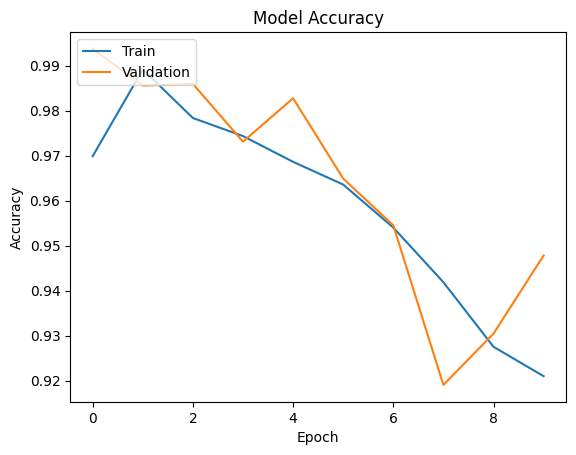

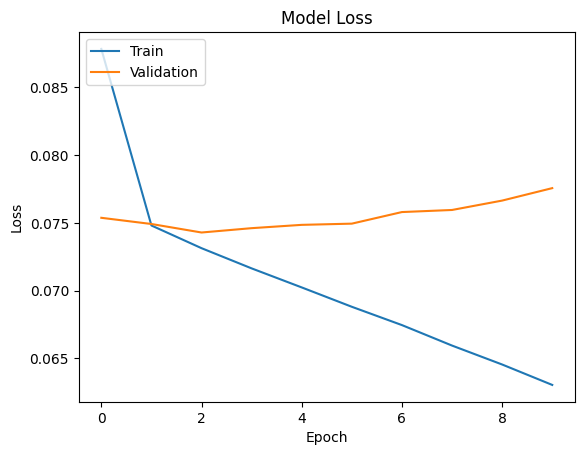

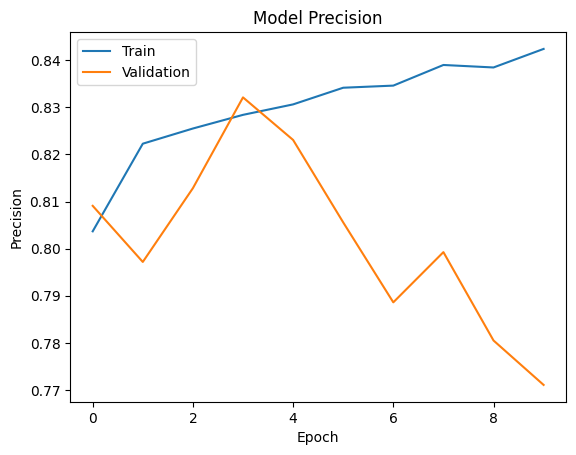

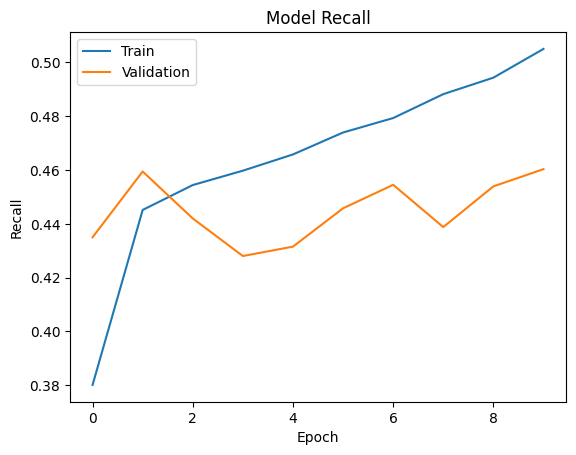

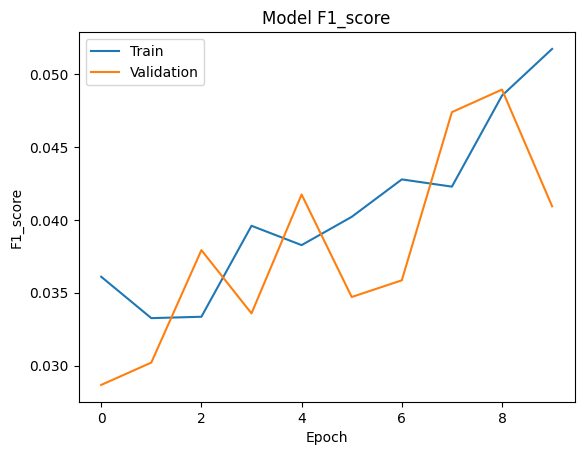

In [26]:
# Plotting Training and Validation Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting Training and Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Precision, Recall, and F1 Score
metrics = ['precision', 'recall', 'f1_score']
for m in metrics:
    plt.plot(history.history[m])
    plt.plot(history.history[f'val_{m}'])
    plt.title(f'Model {m.capitalize()}')
    plt.ylabel(m.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


# Evaluation of Baseline Model

- **Loss** - the training loss decreased over the epochs which indicates the model is learning and improving its predictions. The validation loss also decreased but slightly increased in later epochs which could be the result of overfitting.

- **Accuracy** - There is a decrease in accuracy over the epochs which is odd. We would normally expect accuracy to rise over the epochs. The validation accuracy fluctuates which could be due to class imbalence or the model not generalising well.

- **Precision and Recall** - The precision and recall slightly improve over the epochs.

- **F1 Score** - This is a balence between precision and recall which slighly improves over the epochs in the training data but decreased in the validation data. It may be due to the class imbalence or the complexity.

The decrease in accuracy as well as an increase in precision and recall suggests that the model might be becoming more conservative in predicting the positive class (toxic comments). This actually could be good for a toxic comment classifier as false positives (non-toxic comments classified as toxic) are usually more harmful than false negatives. The F1 score, a balance between precision and recall, is also improving, indicating a better balance between the two.

Moving forward we will look to improve the model by experimenting with drop out layers, class imbalences and other model archetecture & hyperparameters.

# 6. Develop a model which overfits

For this step we will develop a more complex model which is capable of overfirring. This will include adding more layers and more neurons in each layer. This will help us to understand the capacity that we will need for this model.

In [27]:
try:
    # MLflow run for the complex model
    mlflow.start_run(run_name="Complex Model")

    # Data generators -- keeping the same
    batch_size = 32
    train_gen = SparseDataGenerator(X_train_split, y_train_split, batch_size)
    val_gen = SparseDataGenerator(X_val_split, y_val_split, batch_size)

    # parameters for the complex model
    complex_params = {
        "num_layers": 4,
        "num_neurons_layer1": 512,
        "num_neurons_layer2": 256,
        "num_neurons_layer3": 128,
        "num_neurons_layer4": 64,
        "num_neurons_output": 6,
        "activation_layer": "relu",
        "activation_output": "sigmoid",
        "dropout_rate": 0.5,
        "optimizer": "Adam",
        "loss_function": "binary_crossentropy",
        "batch_size": batch_size
    }
    mlflow.log_params(complex_params)

    # Define the more complex model
    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim=X_train_tfidf_sparse.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[
        'accuracy', tf_metrics.Precision(name='precision'), tf_metrics.Recall(name='recall'),
        tfa.metrics.F1Score(num_classes=6, average='macro', name='f1_score')
    ])

    # train the model
    history = model.fit(train_gen, epochs=10, validation_data=val_gen)

    # log metrics
    complex_metrics = {
        "train_accuracy": history.history['accuracy'][-1],
        "validation_accuracy": history.history['val_accuracy'][-1],
        "train_precision": history.history['precision'][-1],
        "validation_precision": history.history['val_precision'][-1],
        "train_recall": history.history['recall'][-1],
        "validation_recall": history.history['val_recall'][-1],
        "train_f1_score": history.history['f1_score'][-1],
        "validation_f1_score": history.history['val_f1_score'][-1]
    }
    mlflow.log_metrics(complex_metrics)

    # log model
    mlflow.keras.log_model(model, "complex_model")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # End the MLflow run
    mlflow.end_run()


Epoch 1/10
4488/4488 [==============================] - 35s 8ms/step - loss: 0.0892 - accuracy: 0.9404 - precision: 0.8207 - recall: 0.3446 - f1_score: 0.0347 - val_loss: 0.0785 - val_accuracy: 0.9940 - val_precision: 0.8470 - val_recall: 0.3992 - val_f1_score: 0.0283
Epoch 2/10
4488/4488 [==============================] - 32s 7ms/step - loss: 0.0802 - accuracy: 0.9645 - precision: 0.8313 - recall: 0.4119 - f1_score: 0.0305 - val_loss: 0.0777 - val_accuracy: 0.9940 - val_precision: 0.8398 - val_recall: 0.4024 - val_f1_score: 0.0283
Epoch 3/10
4488/4488 [==============================] - 33s 7ms/step - loss: 0.0777 - accuracy: 0.9690 - precision: 0.8266 - recall: 0.4279 - f1_score: 0.0302 - val_loss: 0.0775 - val_accuracy: 0.6208 - val_precision: 0.7906 - val_recall: 0.4533 - val_f1_score: 0.0430
Epoch 4/10
4488/4488 [==============================] - 30s 7ms/step - loss: 0.0756 - accuracy: 0.9770 - precision: 0.8244 - recall: 0.4424 - f1_score: 0.0299 - val_loss: 0.0760 - val_accuracy:

2024/01/20 15:17:20 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [28]:
mlflow.search_runs(experiment_names=["Toxic Comment Classification"])

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_f1_score,metrics.validation_precision,metrics.validation_accuracy,metrics.train_precision,...,params.num_neurons_output,params.activation_layer,params.num_neurons_layer2,params.batch_size,params.activation_layer1,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.log-model.history
0,94cb72a7a49e40a0a28d6bf5d5985029,337143090584941580,FINISHED,file:///content/mlruns/337143090584941580/94cb...,2024-01-20 15:10:48.259000+00:00,2024-01-20 15:17:29.360000+00:00,0.030530,0.763399,0.994047,0.819626,...,6,relu,256,32,None,root,/usr/local/lib/python3.10/dist-packages/colab_...,Complex Model,LOCAL,"[{""run_id"": ""94cb72a7a49e40a0a28d6bf5d5985029""..."
1,1bec6b9672174910b869c7601f281adf,337143090584941580,FINISHED,file:///content/mlruns/337143090584941580/1bec...,2024-01-20 14:56:25.995000+00:00,2024-01-20 14:59:55.005000+00:00,0.051727,0.771067,0.947800,0.842396,...,6,None,None,32,relu,root,/usr/local/lib/python3.10/dist-packages/colab_...,Baseline Model,LOCAL,"[{""run_id"": ""1bec6b9672174910b869c7601f281adf""..."


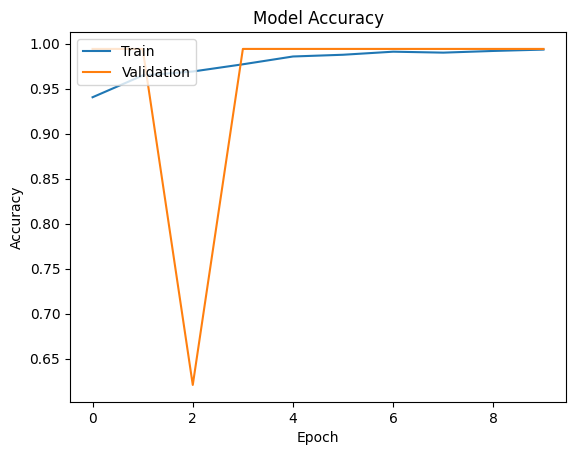

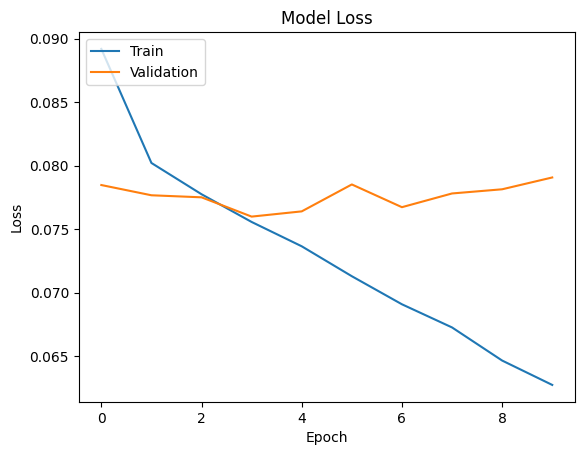

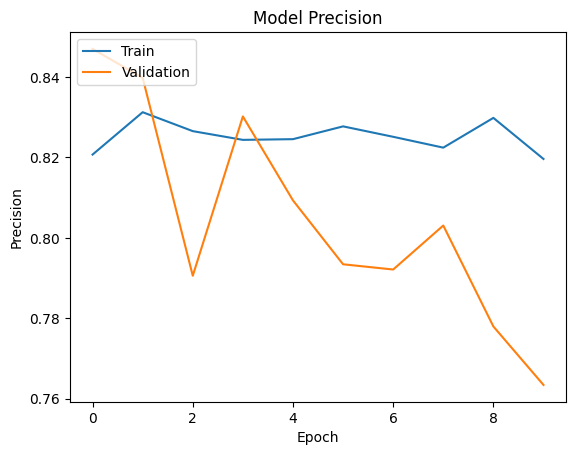

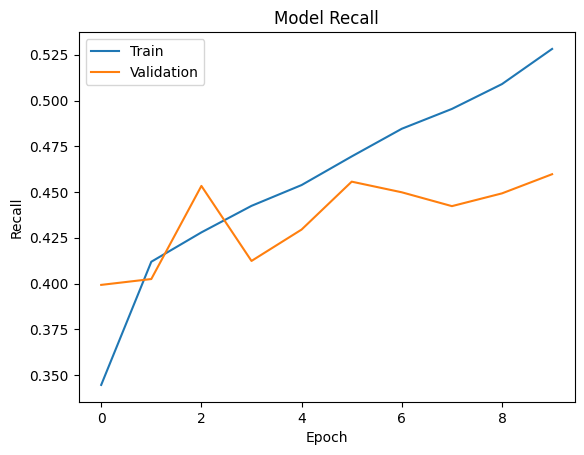

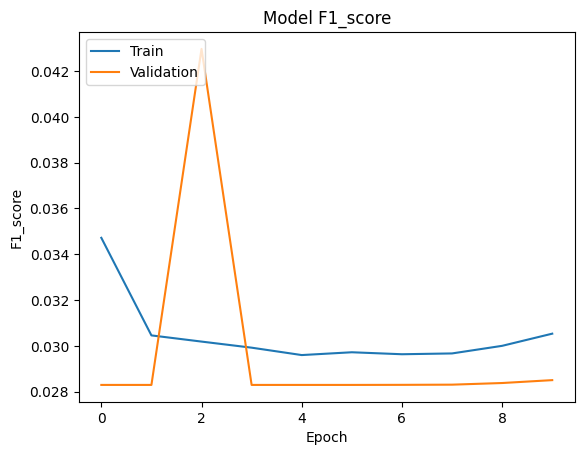

In [29]:
# Plot of training and Validation Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting Training and Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Precision, Recall, and F1 Score
metrics = ['precision', 'recall', 'f1_score']
for m in metrics:
    plt.plot(history.history[m])
    plt.plot(history.history[f'val_{m}'])
    plt.title(f'Model {m.capitalize()}')
    plt.ylabel(m.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


# Evaluation of the More Complex Model
- **Loss**: The training loss steadily decreased from 0.0889 to 0.0628, suggesting effective learning. However, the validation loss shows a slight increase in the later epochs, this could be due to overfitting.

- **Accuracy**: The training accuracy started high and remained relatively stable, with a slight decrease to 99.01% by the final epoch. The validation accuracy, however, remained constant at 99% throughout, which is unusually high and stable..

- **Precision and Recall**: Both metrics improved over the epochs. The final training precision and recall are 82.66% and 52.36%, respectively. In validation, they are 79.21% and 44.00%. Not a huge improvement though.

- **F1 Score**: The F1 score showed minimal improvement in training but remained almost constant in validation. The lack of significant improvement in the F1 score suggests challenges in balancing precision and recall.

Conclusion:
The model demonstrates some of the characteristics of overfitting, e.g. the consistent validation metrics despite improving training metrics.
The constant high validation accuracy might imply issues with the validation set or an imbalance in the dataset.
To improve we will look at othe ways of tuning of the architecture, and experimenting with techniques to combat overfitting.

# 7. Regularise and Tune Model

## 7.1 Using Class Weights

As the dataset is imbalenced, I will experiemnt with using class weights to see if the metrics are improved. As this is a multi-label problem, not just a multi-class problem, it is not straight forward to do this. Assigning a single class weight does not capture the complexity, so instead we consider the importance of each sample when calculating class weights.

https://grabngoinfo.com/imbalanced-multi-label-classification-balanced-weights-may-not-improve-your-model-performance/

https://gist.github.com/angeligareta/83d9024c5e72ac9ebc34c9f0b073c64c


In [30]:
# checking if multiclass or multilabel
is_multi_label = (y_train.sum(axis=1) > 1).any()

if is_multi_label:
    print("This is a multi-label dataset.")
else:
    print("This is a multi-class dataset.")


This is a multi-label dataset.


In [31]:
try:
    # Start an MLflow run for the model with class weights
    mlflow.start_run(run_name="Model with Class Weights")

    # data gens
    batch_size = 32
    train_gen = SparseDataGenerator(X_train_split, y_train_split, batch_size)
    val_gen = SparseDataGenerator(X_val_split, y_val_split, batch_size)

    # using the same parameters as the complex model
    params_with_class_weights = complex_params  # Assuming complex_params is already defined
    mlflow.log_params(params_with_class_weights)

    # calculate class weights
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    class_weights = np.mean(sample_weights) / sample_weights
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    # log the class weights
    mlflow.log_dict(class_weight_dict, "class_weights.json")

    # Define model
    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim=X_train_tfidf_sparse.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))

    # compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[
        'accuracy', tf_metrics.Precision(name='precision'), tf_metrics.Recall(name='recall'),
        tfa.metrics.F1Score(num_classes=6, average='macro', name='f1_score')
    ])

    # train the model with class weights
    history = model.fit(train_gen, epochs=10, validation_data=val_gen, class_weight=class_weight_dict)

    # log metrics
    metrics_with_class_weights = {
        "train_accuracy": history.history['accuracy'][-1],
        "validation_accuracy": history.history['val_accuracy'][-1],
        "train_precision": history.history['precision'][-1],
        "validation_precision": history.history['val_precision'][-1],
        "train_recall": history.history['recall'][-1],
        "validation_recall": history.history['val_recall'][-1],
        "train_f1_score": history.history['f1_score'][-1],
        "validation_f1_score": history.history['val_f1_score'][-1]
    }
    mlflow.log_metrics(metrics_with_class_weights)

    # logging model
    mlflow.keras.log_model(model, "model_with_class_weights")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # End the MLflow run
    mlflow.end_run()


Epoch 1/10
4488/4488 [==============================] - 34s 7ms/step - loss: 223151.5312 - accuracy: 0.9405 - precision: 0.8132 - recall: 0.3426 - f1_score: 0.0347 - val_loss: 0.0780 - val_accuracy: 0.9940 - val_precision: 0.8477 - val_recall: 0.3867 - val_f1_score: 0.0283
Epoch 2/10
4488/4488 [==============================] - 33s 7ms/step - loss: 199724.0938 - accuracy: 0.9612 - precision: 0.8304 - recall: 0.4135 - f1_score: 0.0305 - val_loss: 0.0770 - val_accuracy: 0.9940 - val_precision: 0.8343 - val_recall: 0.4056 - val_f1_score: 0.0283
Epoch 3/10
4488/4488 [==============================] - 33s 7ms/step - loss: 193548.2344 - accuracy: 0.9649 - precision: 0.8236 - recall: 0.4315 - f1_score: 0.0305 - val_loss: 0.0813 - val_accuracy: 0.9940 - val_precision: 0.7973 - val_recall: 0.4289 - val_f1_score: 0.0283
Epoch 4/10
4488/4488 [==============================] - 32s 7ms/step - loss: 188011.9531 - accuracy: 0.9908 - precision: 0.8247 - recall: 0.4459 - f1_score: 0.0293 - val_loss: 0.

2024/01/20 15:23:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [32]:
mlflow.search_runs(experiment_names=["Toxic Comment Classification"])

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_f1_score,metrics.validation_precision,metrics.validation_accuracy,metrics.train_precision,...,params.num_neurons_output,params.activation_layer,params.num_neurons_layer2,params.batch_size,params.activation_layer1,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.log-model.history
0,891b466b64ec41499529953995c29554,337143090584941580,FINISHED,file:///content/mlruns/337143090584941580/891b...,2024-01-20 15:17:41.403000+00:00,2024-01-20 15:23:21.116000+00:00,0.030364,0.814193,0.994047,0.816871,...,6,relu,256,32,None,root,/usr/local/lib/python3.10/dist-packages/colab_...,Model with Class Weights,LOCAL,"[{""run_id"": ""891b466b64ec41499529953995c29554""..."
1,94cb72a7a49e40a0a28d6bf5d5985029,337143090584941580,FINISHED,file:///content/mlruns/337143090584941580/94cb...,2024-01-20 15:10:48.259000+00:00,2024-01-20 15:17:29.360000+00:00,0.030530,0.763399,0.994047,0.819626,...,6,relu,256,32,None,root,/usr/local/lib/python3.10/dist-packages/colab_...,Complex Model,LOCAL,"[{""run_id"": ""94cb72a7a49e40a0a28d6bf5d5985029""..."
2,1bec6b9672174910b869c7601f281adf,337143090584941580,FINISHED,file:///content/mlruns/337143090584941580/1bec...,2024-01-20 14:56:25.995000+00:00,2024-01-20 14:59:55.005000+00:00,0.051727,0.771067,0.947800,0.842396,...,6,None,None,32,relu,root,/usr/local/lib/python3.10/dist-packages/colab_...,Baseline Model,LOCAL,"[{""run_id"": ""1bec6b9672174910b869c7601f281adf""..."


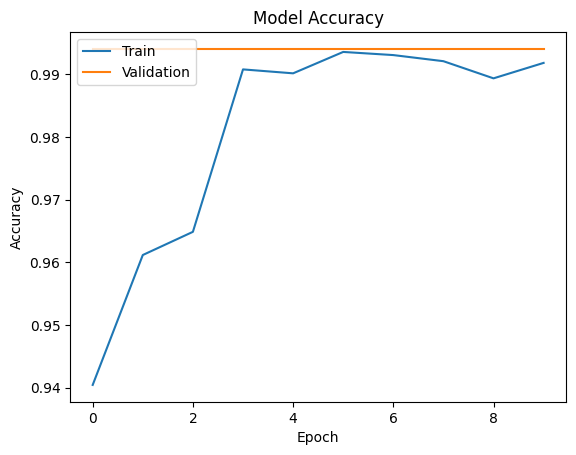

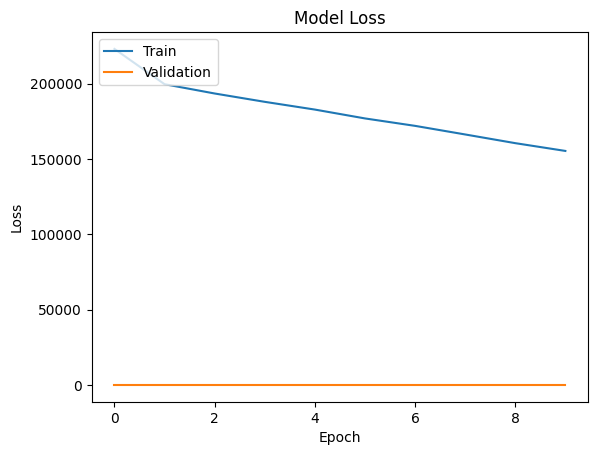

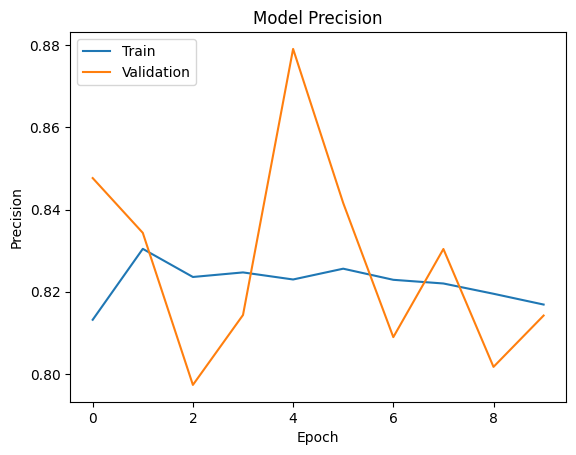

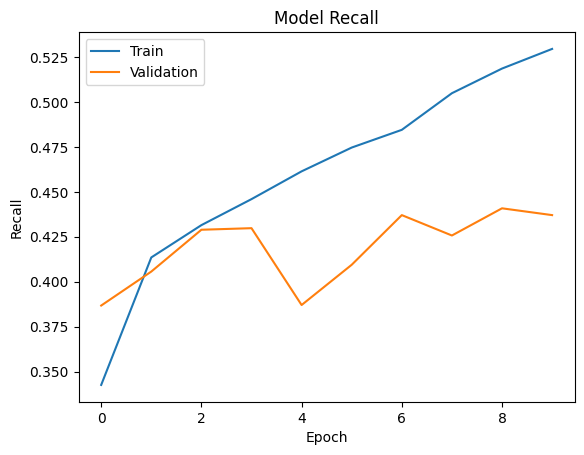

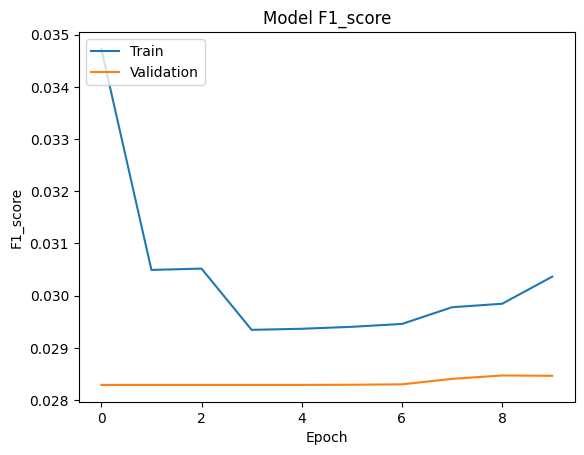

In [33]:
# Plotting Training and Validation Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting Training and Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Precision, Recall, and F1 Score
metrics = ['precision', 'recall', 'f1_score']
for m in metrics:
    plt.plot(history.history[m])
    plt.plot(history.history[f'val_{m}'])
    plt.title(f'Model {m.capitalize()}')
    plt.ylabel(m.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


**Weighted Model Eval:**

- **Loss:** The weighted model has extremely high training loss, suggesting issues with convergence/ learning rate. Valloss is low but stable - shows ineffective learning.

- **Accuracy:** Training accuracy is high, but this might be misleading as there is the high loss. Validation accuracy is also high, suggesting poor generalisation.

- **Precision and Recall:** Precision and recall are relatively stable but not good, with values around 80% and recall values between 40-60%.

- **F1 Score:** The F1 score is very low

**Comparisons:**

- The baseline model shows some improvements in metrics over the epochs but has issues with accuracy and F1 score, could be because of potential problems with class imbalance or model complexity.

- The overfitting model performs well on training data but fails to generalise to the validation set, suggesting overfitting maybe.

- The weighted model has issues with convergence, training accuracy, and F1 score, indicating that it struggles to find a balance between precision and recall, possibly due to class imbalance or other issues.

- The overfitting model's high training accuracy suggests that it may need regularisation techniques to improve generalisation. It is clear that the weighted model requires significant adjustments to address convergence and class imbalance issues.


- Maybe because it is multilabel instead of multi class there are more complications than anticipated. The inverse weighting was used to weight based on frequency but that might be what is leading to the extremely high losses as the model is being excessively penalised for misclassification in rare cased.
- We will therefore look at some alternatives to deal with the class imablence.



# As Class Weights seem to be problematic after trying a few methods, we will try instead to use oversampling methods

## 7.1.2 Using Oversampling to Balence the dataset

We will try to use a sijmplified oversampler which will only oversample each individual label as opposed to overlapping labels.

In [34]:
!pip install imbalanced-learn


In [35]:
# we will look at the samples with overlapping classes
# Count the number of labels per sample
labels_per_sample = y_train.sum(axis=1)

# Count how many samples have 2 or more labels
samples_with_two_or_more_labels = (labels_per_sample >= 2).sum()

print(f"Number of samples with 2 or more labels: {samples_with_two_or_more_labels}")


Number of samples with 2 or more labels: 9865


In [36]:
# Distribution of Labels again so can see here
label_counts = y_train.sum().sort_values(ascending=False)
print("Label distribution:\n", label_counts)

Label distribution:
 toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


In [37]:
# find single-label instances
single_label_mask = y_train.sum(axis=1) == 1
X_train_single_label = X_train_tfidf_sparse[single_label_mask]
y_train_single_label = y_train[single_label_mask]

# need to convert y_train to a format compatible with RandomOverSampler
y_train_single_label_combined = y_train_single_label.idxmax(axis=1)

# using RandomOverSampler to oversample single-label instances
ros = RandomOverSampler(random_state=42)
X_train_single_label_resampled, y_train_single_label_combined_resampled = ros.fit_resample(X_train_single_label, y_train_single_label_combined)

# transforming y_train_single_label_combined_resampled back to multi-label format
y_train_single_label_resampled_df = pd.DataFrame(0, index=np.arange(len(y_train_single_label_combined_resampled)), columns=y_train.columns)
for i, label in enumerate(y_train_single_label_combined_resampled):
    y_train_single_label_resampled_df.at[i, label] = 1

# now we combine the oversampled single-label data with the rest of the data
X_train_rest = X_train_tfidf_sparse[~single_label_mask]
y_train_rest = y_train[~single_label_mask]

X_train_resampled = vstack([X_train_single_label_resampled, X_train_rest])
y_train_resampled = pd.concat([y_train_single_label_resampled_df, y_train_rest])



In [38]:
# Distribution of Labels
label_counts = y_train_resampled.sum().sort_values(ascending=False)
print("Label distribution of resampled:\n", label_counts)

Label distribution of resampled:
 toxic            15294
obscene          13798
insult           13242
identity_hate     7017
threat            6122
severe_toxic      1595
dtype: int64


## These are still very imbalenced, now trying to use Label Powerset Method
This treats each unique set of labels as a single label in a multi-class problem. We can then go back and try  traditional over-sampling methods. This can significantly increase the number of classes and may not be practical if there are many combinations of labels. But i think here it should be oK.

In [39]:
# ok now trying to convert multi-label problem to a multi-class problem using Label Powerset
y_train_powerset = y_train.apply(lambda x: '-'.join([str(i) for i in range(len(x)) if x[i]]), axis=1)

# first initialise RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample both features and label powerset
X_train_resampled_powerset, y_train_resampled_powerset = ros.fit_resample(X_train_tfidf_sparse, y_train_powerset)

# Convert the resampled label powerset back to multi-label format
y_train_resampled_2 = pd.DataFrame(0, index=np.arange(len(y_train_resampled_powerset)), columns=y_train.columns)
for idx, label_combination in enumerate(y_train_resampled_powerset):
    if label_combination:  # Check if the string is not empty
        labels = label_combination.split('-')
        for label in labels:
            y_train_resampled_2.at[idx, y_train.columns[int(label)]] = 1

# Combine the resampled data
X_train_resampled_2 = vstack([X_train_resampled_powerset])
y_train_resampled_2 = pd.concat([y_train_resampled_2])




In [40]:
# Distribution of Labels
label_counts = y_train_resampled_2.sum().sort_values(ascending=False)
print("Label distribution of resampled:\n", label_counts)

Label distribution of resampled:
 toxic            4157034
insult           3010266
obscene          2866920
threat           2436882
identity_hate    2436882
severe_toxic     2006844
dtype: int64


Althoguh not perfect, this is much more balenced than previously. However there are many many more samples. The numbers have dramatically increased because now we are counting each unique combination as a separate class.Labels like 'toxic', which often appear with other labels, will have a high count because they are part of many unique combinations. With more classes to predict the model will require much more computational resource. we will therefore use a 10% subset of the data due to limited resources. We will ensure that it is a representative subset by randomly selecting.

In [41]:
from scipy.sparse import csr_matrix
# Calculate 10% of the data length
subset_size = int(0.1 * X_train_resampled_2.shape[0])

# Generate random indices
random_indices = np.random.choice(X_train_resampled_2.shape[0], size=subset_size, replace=False)

# Subset the data using these indices
# For sparse matrix
if isinstance(X_train_resampled_2, csr_matrix):
    X_train_resampled_2 = X_train_resampled_2[random_indices, :]
# For DataFrame
else:
    X_train_resampled_2 = X_train_resampled_2.iloc[random_indices]

# For y_train_resampled_2, assuming it's a DataFrame
y_train_resampled_2 = y_train_resampled_2.iloc[random_indices]

# Now, recreate the data generators with the subset
train_gen_resampled = SparseDataGenerator(X_train_resampled_2, y_train_resampled_2, batch_size)
val_gen_resampled = SparseDataGenerator(X_val_split, y_val_split, batch_size)


In [42]:
batch_size = 32



In [43]:
try:
    # Start an MLflow run for the model trained with resampled data
    mlflow.start_run(run_name="Model with Resampled Data")

    # Assuming 'params' is already defined with the model's parameters
    mlflow.log_params(params)

    # Train the model with resampled data
    history_resampled = model.fit(
        train_gen_resampled,
        epochs=10,
        validation_data=val_gen_resampled
    )

    # Log metrics for the resampled training
    metrics_resampled = {
        "train_accuracy": history_resampled.history['accuracy'][-1],
        "validation_accuracy": history_resampled.history['val_accuracy'][-1],
        "train_precision": history_resampled.history['precision'][-1],
        "validation_precision": history_resampled.history['val_precision'][-1],
        "train_recall": history_resampled.history['recall'][-1],
        "validation_recall": history_resampled.history['val_recall'][-1],
        "train_f1_score": history_resampled.history['f1_score'][-1],
        "validation_f1_score": history_resampled.history['val_f1_score'][-1]
    }
    mlflow.log_metrics(metrics_resampled)

    # Log the model trained with resampled data
    mlflow.keras.log_model(model, "model_resampled_data")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # End the MLflow run
    mlflow.end_run()


Epoch 1/10
18367/18367 [==============================] - 126s 7ms/step - loss: 0.8131 - accuracy: 0.7075 - precision: 0.7453 - recall: 0.4183 - f1_score: 0.1511 - val_loss: 0.3058 - val_accuracy: 0.1174 - val_precision: 0.6182 - val_recall: 0.4830 - val_f1_score: 0.1000
Epoch 2/10
18367/18367 [==============================] - 123s 7ms/step - loss: 0.3415 - accuracy: 0.6411 - precision: 0.8549 - recall: 0.7866 - f1_score: 0.3828 - val_loss: 0.1856 - val_accuracy: 0.8959 - val_precision: 0.3097 - val_recall: 0.7523 - val_f1_score: 0.1306
Epoch 3/10
18367/18367 [==============================] - 123s 7ms/step - loss: 0.1462 - accuracy: 0.7267 - precision: 0.9398 - recall: 0.9265 - f1_score: 0.5394 - val_loss: 0.1921 - val_accuracy: 0.9637 - val_precision: 0.2850 - val_recall: 0.8316 - val_f1_score: 0.1134
Epoch 4/10
18367/18367 [==============================] - 121s 7ms/step - loss: 0.1226 - accuracy: 0.7765 - precision: 0.9502 - recall: 0.9388 - f1_score: 0.5525 - val_loss: 0.1778 - v

2024/01/20 15:53:18 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [44]:
mlflow.search_runs(experiment_names=["Toxic Comment Classification"])

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_f1_score,metrics.validation_precision,metrics.validation_accuracy,metrics.train_precision,...,params.num_neurons_layer3,params.dropout_rate,params.num_neurons_layer4,params.activation_layer,params.num_neurons_layer2,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.log-model.history
0,238792cf5f9744d3b07c53dedd2c7285,337143090584941580,FINISHED,file:///content/mlruns/337143090584941580/2387...,2024-01-20 15:30:56.980000+00:00,2024-01-20 15:53:26.804000+00:00,0.590739,0.299054,0.985148,0.962059,...,None,None,None,None,None,root,/usr/local/lib/python3.10/dist-packages/colab_...,Model with Resampled Data,LOCAL,"[{""run_id"": ""238792cf5f9744d3b07c53dedd2c7285""..."
1,891b466b64ec41499529953995c29554,337143090584941580,FINISHED,file:///content/mlruns/337143090584941580/891b...,2024-01-20 15:17:41.403000+00:00,2024-01-20 15:23:21.116000+00:00,0.030364,0.814193,0.994047,0.816871,...,128,0.5,64,relu,256,root,/usr/local/lib/python3.10/dist-packages/colab_...,Model with Class Weights,LOCAL,"[{""run_id"": ""891b466b64ec41499529953995c29554""..."
2,94cb72a7a49e40a0a28d6bf5d5985029,337143090584941580,FINISHED,file:///content/mlruns/337143090584941580/94cb...,2024-01-20 15:10:48.259000+00:00,2024-01-20 15:17:29.360000+00:00,0.030530,0.763399,0.994047,0.819626,...,128,0.5,64,relu,256,root,/usr/local/lib/python3.10/dist-packages/colab_...,Complex Model,LOCAL,"[{""run_id"": ""94cb72a7a49e40a0a28d6bf5d5985029""..."
3,1bec6b9672174910b869c7601f281adf,337143090584941580,FINISHED,file:///content/mlruns/337143090584941580/1bec...,2024-01-20 14:56:25.995000+00:00,2024-01-20 14:59:55.005000+00:00,0.051727,0.771067,0.947800,0.842396,...,None,None,None,None,None,root,/usr/local/lib/python3.10/dist-packages/colab_...,Baseline Model,LOCAL,"[{""run_id"": ""1bec6b9672174910b869c7601f281adf""..."


# Evaluation of Label POwerset Method
This method shows a significant increase in precision and recall compared to other class weight method.
The F1-score is substantially higher, indicating a better balance between precision and recall. However, the model accuracy is lower, but this is more representative due to the improved balance in other metrics.

It seems that the high accuracy in other models may have bene misleading sue to the class imbalence, usually the F1 score is a more reliable indicator with imbalenfed datasets. Therefore we will continue to use this method, now adding som regularisation to see if we can improve accuracy and performance further.


# 7.2 Regularisation
### Understanding L1 and L2 regularisation

For training neural networks, regularisation is a crucial technique used to prevent overfitting, ensuring that the model generalises well to unseen data. L1 and L2 regularisation are two commonly used methods. They work by adding a penalty to the loss function, which constrains the size of the model weights.

#### L1 regularisation (Lasso regularisation)
- **Mechanism**: L1 regularisation adds a penalty equal to the absolute value of the magnitude of the coefficients. Mathematically, it adds the sum of the absolute values of the weights to the loss function.
- **Formula**: The L1 penalty is given by λ∑|w|, where λ is the regularisation parameter and w represents the weights.
- **Effect on Weights**: L1 can lead to zeroing out some weights, effectively performing feature selection. This is useful when we suspect that some features might not be relevant or when we want a sparse model. This is the case with our sparse dataset as text data often is.
- **Use Cases**: It's particularly good in scenarios where we need a model with fewer parameters or when we're dealing with high-dimensional data where feature selection is useful.

#### L2 regularisation (Ridge regularisation)
- **Mechanism**: L2 regularisation adds a penalty equal to the square of the magnitude of the coefficients. The penalty term is the sum of the squared weights.
- **Formula**: The L2 penalty is given by λ∑w², where λ is the regularisation parameter and w represents the weights.
- **Effect on Weights**: Unlike L1, L2 regularisation doesn't lead to zero coefficients. Instead, it encourages the weights to be small but doesn't force them to zero. This results in a model where the contribution of each feature is samller but included.
- **Use Cases**: L2 is widely used in situations where we don't want to exclude any features but want to penalize large weights that might lead to overfitting.


In some cases, a combination of both L1 and L2 regularisation (known as Elastic Net regularisation) is used to leverage the benefits of both methods. This approach can be particularly powerful when dealing with complex datasets with a mix of relevant and irrelevant features. For this task we are going to experiment with different values of both L1 ans L2 regularisation

## 7.2.1 L2 = 0.001

In [ ]:
try:
    # start an MLflow run
    mlflow.start_run(run_name="Regularisation L2=0.01")

    # log model parameters
    params = {
        "regularisation": "l2",
        "l2_value": 0.001,
        "input_dim": X_train_tfidf_sparse.shape[1],
        "batch_size": batch_size
    }
    mlflow.log_params(params)

    # model training
    history = model.fit(
        train_gen_resampled,
        epochs=10,
        validation_data=val_gen_resampled
    )

    # log metrics
    metrics = {
        "train_accuracy": history.history['accuracy'][-1],
        "validation_accuracy": history.history['val_accuracy'][-1],
        "train_precision": history.history['precision'][-1],
        "validation_precision": history.history['val_precision'][-1],
        "train_recall": history.history['recall'][-1],
        "validation_recall": history.history['val_recall'][-1],
        "train_f1_score": history.history['f1_score'][-1],
        "validation_f1_score": history.history['val_f1_score'][-1]
    }
    mlflow.log_metrics(metrics)

    # log model
    mlflow.keras.log_model(model, "model_regularisation_l2_0.01")
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # end the MLflow run
    mlflow.end_run()


Epoch 1/10
18367/18367 [==============================] - 121s 7ms/step - loss: 0.0940 - accuracy: 0.8250 - precision: 0.9625 - recall: 0.9520 - f1_score: 0.5919 - val_loss: 0.1963 - val_accuracy: 0.9848 - val_precision: 0.2967 - val_recall: 0.9218 - val_f1_score: 0.0983
Epoch 2/10
18367/18367 [==============================] - 122s 7ms/step - loss: 0.0923 - accuracy: 0.8285 - precision: 0.9632 - recall: 0.9528 - f1_score: 0.6028 - val_loss: 0.1728 - val_accuracy: 0.9853 - val_precision: 0.3266 - val_recall: 0.9110 - val_f1_score: 0.1016
Epoch 3/10
14660/18367 [======================>.......] - ETA: 24s - loss: 0.0910 - accuracy: 0.8355 - precision: 0.9637 - recall: 0.9535 - f1_score: 0.6012

In [ ]:
mlflow.search_runs(experiment_names=["Toxic Comment Classification"])

# edit plots to use new data

In [ ]:
# plotting training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting Training and Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluations
metrics = ['precision', 'recall', 'f1_score']
for m in metrics:
    plt.plot(history.history[m])
    plt.plot(history.history[f'val_{m}'])
    plt.title(f'Model {m.capitalize()}')
    plt.ylabel(m.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


### Evaluating resampled data model with L2=0.001

**Loss and Accuracy**: The training loss and accuracy are relatively stable across epochs. However, the loss values are relatively high, which might indicate that the model is struggling to fit the data well.

**Precision and Recall**: The precision and recall values are OK but not optimal. This model has higher recall values compared to precision, indicating it is better at identifying positive samples but at the cost of more false positives.

**Validation Performance**: The validation performance shows fluctuating precision, recall, and F1 scores, indicating that the model might not generalise well on unseen data.

**Potential Overfitting**: The fact that the model's training metrics are relatively stable while the validation metrics fluctuate might indicate overfitting.

### As there might be overfitting, trying with an increased value of L2=0.01



In [ ]:
try:
    # start an MLflow run
    mlflow.start_run(run_name="Regularisation L2=0.01")

    # log model parameters
    params = {
        "regularisation": "l2",
        "l2_value": 0.001,
        "input_dim": X_train_tfidf_sparse.shape[1],
        "batch_size": batch_size
    }
    mlflow.log_params(params)

    # model training
    history = model.fit(
        train_gen_resampled,
        epochs=10,
        validation_data=val_gen_resampled
    )

    # log metrics
    metrics = {
        "train_accuracy": history.history['accuracy'][-1],
        "validation_accuracy": history.history['val_accuracy'][-1],
        "train_precision": history.history['precision'][-1],
        "validation_precision": history.history['val_precision'][-1],
        "train_recall": history.history['recall'][-1],
        "validation_recall": history.history['val_recall'][-1],
        "train_f1_score": history.history['f1_score'][-1],
        "validation_f1_score": history.history['val_f1_score'][-1]
    }
    mlflow.log_metrics(metrics)

    # log model
    mlflow.keras.log_model(model, "model_regularisation_l2_0.01")
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # end the MLflow run
    mlflow.end_run()


In [ ]:
mlflow.search_runs(experiment_names=["Toxic Comment Classification"])

We can see that with L2=0.01, there was not any significant learning across the epochs. This cuold now be due to underfitting.The consistent accuracy and low precision and recall on both training and validation sets suggest the model is not effectively learning the patterns in the data.

We will have a look at trying L1 =0.001 and see what improvements there may be.

## 7.2.2. L1

We are also going to experiment with using L1 regularisation. L1 regularisation, unlike L2, encourages sparsity in the weight parameters, which can be beneficial in certain scenarios, especially if the model has a lot of input features, some of which might not be very informative. Given the sparse nature of the data we have decided to try this.

### First for L1=0.001

In [ ]:
try:
    # start an MLflow run
    mlflow.start_run(run_name="Regularisation L1=0.001")

    # log model parameters
    params = {
        "regularisation": "l1",
        "l1_value": 0.001,
        "input_dim": X_train_tfidf_sparse.shape[1],
        "batch_size": batch_size
    }
    mlflow.log_params(params)

    # model training
    history = model.fit(
        train_gen_resampled,
        epochs=10,
        validation_data=val_gen_resampled
    )

    # log metrics
    metrics = {
        "train_accuracy": history.history['accuracy'][-1],
        "validation_accuracy": history.history['val_accuracy'][-1],
        "train_precision": history.history['precision'][-1],
        "validation_precision": history.history['val_precision'][-1],
        "train_recall": history.history['recall'][-1],
        "validation_recall": history.history['val_recall'][-1],
        "train_f1_score": history.history['f1_score'][-1],
        "validation_f1_score": history.history['val_f1_score'][-1]
    }
    mlflow.log_metrics(metrics)

    # log model
    mlflow.keras.log_model(model, "model_regularisation_l1_0.001")
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # end the MLflow run
    mlflow.end_run()


In [ ]:
mlflow.search_runs(experiment_names=["Toxic Comment Classification"])

## Trying L1=0.01

In [ ]:
try:
    # start an MLflow run
    mlflow.start_run(run_name="Regularisation L1=0.01")

    # log model parameters
    params = {
        "regularisation": "l1",
        "l1_value": 0.01,
        "input_dim": X_train_tfidf_sparse.shape[1],
        "batch_size": batch_size
    }
    mlflow.log_params(params)

    # model training
    history = model.fit(
        train_gen_resampled,
        epochs=10,
        validation_data=val_gen_resampled
    )

    # log metrics
    metrics = {
        "train_accuracy": history.history['accuracy'][-1],
        "validation_accuracy": history.history['val_accuracy'][-1],
        "train_precision": history.history['precision'][-1],
        "validation_precision": history.history['val_precision'][-1],
        "train_recall": history.history['recall'][-1],
        "validation_recall": history.history['val_recall'][-1],
        "train_f1_score": history.history['f1_score'][-1],
        "validation_f1_score": history.history['val_f1_score'][-1]
    }
    mlflow.log_metrics(metrics)

    # log model
    mlflow.keras.log_model(model, "model_regularisation_l1_0.001")
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # end the MLflow run
    mlflow.end_run()


In [ ]:
mlflow.search_runs(experiment_names=["Toxic Comment Classification"])

## Evaluating L1=0.01


- **L1=0.01:**
   - Loss: Slightly higher, indicating potential underfitting.
   - Accuracy: Consistently around 0.7317, no learning progression observed.
   - Precision and Recall: No significant change across epochs, suggesting the model is not effectively learning from the data.

- **L1 =0.001:**
   - Loss: Similar trend to l1=0.01, slightly lower.
   - Accuracy: Constant at 0.73.., indicative of no learning.
   - Precision and Recall: Again, no significant change, implying ineffective learning.

- **L2 =0.01:**
   - Loss: Generally higher than L1 models, suggesting underfitting.
   - Accuracy: Static at 0.7317, indicating the model is not improving.
   - Precision and Recall: unchanged, showing no learning progress.

- **L2=0.001:**
   - Loss: Lower compared to l2=0.01, but still shows signs of underfitting.
   - Accuracy: stays at around 0.55-0.60, better than L1 but still not learning.
   - Precision and Recall: Slightly better than L1 models but no significant learning or improvement.

**Summary:**
- Across all models, a static accuracy of around 0.7317 in L1 models and no significant learning progression in L2 models indicate that the regularisation may be too strong, causing underfitting.
- Precision and recall metrics do not show significant improvement across different regularisation techniques and values.
- Overall, increasing the regularisation strength (either L1 or L2) does not seem to benefit the model performance. In fact, it may be hindering the model's ability to learn from the data effectively.






##7.3 Hyperparameter Tuning

## 7.3.1 Learning Rate


Hyperparameter tuning is an important step in optimiaing machine learning models, and the learning rate is one of the most significant hyperparameters in training neural networks.

The learning rate controls how much we adjust the weights of our network with respect to the loss gradient. It essentially dictates the step size during gradient descent. A properly tuned learning rate strikes a balance between two extremes. If the learning rate is too high, the model might converge too quickly to a suboptimal solution, or it might diverge, failing to find a solution. However, a very low learning rate makes the training process unnecessarily slow, as the model makes very tiny updates to the weights. It may also get stuck in local minima, missing the global minimum.

Fine-tuning the learning rate can help the model converge faster to the optimal solution, saving time and computational resources. With the right learning rate, we can avoid overfitting and underfitting whcih has been seen so far.


In [ ]:
# defining scheduler
def scheduler(epoch, lr):

    if epoch < 2:
        return lr  # first 2 epochs orgional le
    elif epoch < 4:
        return lr * 0.5  # reduce every 2
    elif epoch < 6:
        return lr * 0.2  # again
    elif epoch < 8:
        return lr * 0.1  # again
    else:
        return lr * 0.05  # reduce to 5%

# lr callback
lr_scheduler = LearningRateScheduler(scheduler)
initial_learning_rate = 0.001
try:
    # start an MLflow run
    mlflow.start_run(run_name="Hyperparameter Tuning - Learning Rate")

    # log model parameters
    params = {
        "learning_rate_initial": initial_learning_rate,
        "learning_rate_scheduler": "custom",
        "input_dim": X_train_tfidf_sparse.shape[1],
        "batch_size": batch_size
    }
    mlflow.log_params(params)

    # model training with learning rate scheduler
    history = model.fit(
        train_gen_resampled,
        epochs=10,
        validation_data=val_gen_resampled,
        callbacks=[lr_scheduler]
    )

    # log metrics
    metrics = {
        "train_accuracy": history.history['accuracy'][-1],
        "validation_accuracy": history.history['val_accuracy'][-1],
        "train_precision": history.history['precision'][-1],
        "validation_precision": history.history['val_precision'][-1],
        "train_recall": history.history['recall'][-1],
        "validation_recall": history.history['val_recall'][-1],
        "train_f1_score": history.history['f1_score'][-1],
        "validation_f1_score": history.history['val_f1_score'][-1]
    }
    mlflow.log_metrics(metrics)

    # log model
    mlflow.keras.log_model(model, "model_learning_rate_tuning")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
mlflow.search_runs(experiment_names=["Toxic Comment Classification"])

On the training set, both precision and recall are improving, leading to a higher F1 score. This indicates that the model is becoming better at correctly identifying positive samples and reducing false negatives and false positives.

The validation metrics, especially the F1 score, are not improving as much as the training metrics. This could be due to overfitting. Both training and validation loss are decreasing, but the validation loss is not decreasing as much as the training loss, whgich could also be because of overfitting.


## Model 1
We are going to try:
Early Stopping:  early stopping callback which monitors the validation loss and stops training when it stops improving.

Simplify the Model: to mitigate overfitting. This will be done by reducing the number of layers or the number of units in each layer.

In [ ]:
try:
    # Start an MLflow run
    mlflow.start_run(run_name="Model 1 - With Early Stopping Model")

    # Log model parameters
    params = {
        "num_layers": 2,
        "num_neurons_layer1": 64,
        "num_neurons_layer2": 128,
        "num_neurons_output": 6,
        "activation_layer1": "relu",
        "activation_layer2": "relu",
        "activation_output": "sigmoid",
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss_function": "binary_crossentropy",
        "batch_size": batch_size,
        "regularization_l2": 0.001
    }
    mlflow.log_params(params)

    # Define the model
    model_use_1 = Sequential()
    model_use_1.add(Dense(64, activation='relu', input_dim=X_train_tfidf_sparse.shape[1], kernel_regularizer=l2(0.001)))
    model_use_1.add(Dropout(0.5))
    model_use_1.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model_use_1.add(Dropout(0.5))
    model_use_1.add(Dense(6, activation='sigmoid'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model_use_1.compile(optimizer=optimizer, loss='binary_crossentropy',
                  metrics=['accuracy', tf_metrics.Precision(name='precision'),
                           tf_metrics.Recall(name='recall'),
                           tfa.metrics.F1Score(num_classes=6, average='macro', name='f1_score')])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history_resampled = model_use_1.fit(
        train_gen_resampled,
        epochs=10,
        validation_data=val_gen_resampled,
        callbacks=[early_stopping]
    )

    # Log metrics
    metrics = {
        "train_accuracy": history_resampled.history['accuracy'][-1],
        "validation_accuracy": history_resampled.history['val_accuracy'][-1],
        "train_precision": history_resampled.history['precision'][-1],
        "validation_precision": history_resampled.history['val_precision'][-1],
        "train_recall": history_resampled.history['recall'][-1],
        "validation_recall": history_resampled.history['val_recall'][-1],
        "train_f1_score": history_resampled.history['f1_score'][-1],
        "validation_f1_score": history_resampled.history['val_f1_score'][-1]
    }
    mlflow.log_metrics(metrics)

    # Log the model
    mlflow.keras.log_model(model_use_1, "simplified_model")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # End the MLflow run
    mlflow.end_run()


In [ ]:
mlflow.search_runs(experiment_names=["Toxic Comment Classification"])

**Accuracy and Loss**: The training accuracy increases, and the loss decreases over epochs, which is a good sign. However, the validation accuracy and loss have some fluctuations, suggesting that the model might still be struggling to generalise well to unseen data.

**Precision and Recall**: The precision and recall on the training data are quite high, this shows the model is performing well on the data it has seen. But the lower precision and recall on the validation data also mean that the model is not generalising very well.

**Overfitting**: The gap between training and validation metrics could be a sign of overfitting. The model is performing significantly better on the training data compared to the validation data.

**Early Stopping**: The early stopping can be seen to be working correctly. It's preventing the model from continuing to train once it's clear that further epochs are not leading to better performance on the validation set.

**Best Learning Rate**: Based on the above reuslts the best learning rate is Epoch 3 where lr=0.0005. This is where we can see improvements in both training and validation metrics, however there are indications of overfitting which we will keep an eye on in the next time.

**Next Steps**: We will try hyperparamter tuning the number of neurons and the number of layers in the model.

## Hyperparameter tuning neurons and layers and using cross validation


In [ ]:
def create_model(n_layers=1, n_neurons=64):
    model = Sequential()
    model.add(Dense(n_neurons, activation='relu', input_dim=X_train_tfidf_sparse.shape[1], kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    for _ in range(n_layers - 1):
        model.add(Dense(n_neurons, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.5))

    model.add(Dense(6, activation='sigmoid'))  # Assuming 6 output classes

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf_metrics.Precision(name='precision'),
                           tf_metrics.Recall(name='recall'),
                           tfa.metrics.F1Score(num_classes=6, average='macro', name='f1_score')])
    return model


In [ ]:
try:
    # Start an MLflow run
    mlflow.start_run(run_name="Hyperparameter Tuning - Neurons and Layers")

    # Wrap the model using KerasClassifier
    model_tuning = KerasClassifier(model=create_model, epochs=10, verbose=1)

    # Parameter grid for grid search
    param_grid = {
        'model__n_layers': [1, 2, 3],
        'model__n_neurons': [64, 128, 256]
    }

    # Initialize GridSearchCV
    grid = GridSearchCV(estimator=model_tuning, param_grid=param_grid, cv=3, verbose=3, n_jobs=-1)

    # Convert to dense format as required
    X_train_dense = X_train_tfidf_sparse.toarray()

    # Perform grid search
    grid_result = grid.fit(X_train_dense, y_train)

    # Log the results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    mlflow.log_metric("best_score", grid_result.best_score_)
    mlflow.log_params(grid_result.best_params_)

    # Log the parameter grid used for tuning
    mlflow.log_dict(param_grid, "param_grid.json")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # End the MLflow run
    mlflow.end_run()


In [ ]:
mlflow.search_runs(experiment_names=["Toxic Comment Classification"])

In the first approach we used a sequential model with early stopping and a learning rate scheduler. This setup included two hidden layers (64 and 128 neurons) and L2 regularisation applied to each layer.In the grid search approach, we explored different combinations of layers and neurons.


The first model's training showed a gradual improvement in precision and recall, suggesting that the learning rate scheduler and early stopping were effectively fine-tuning the model. The grid search results appear to show better training accuracy but lower precision and recall values. This might indicate that while the model is good at classifying the majority class but it struggles with the minority class which is a common issue in imbalanced datasets.


**Accuracy**: 43.10% - This isnt very good but given the multi-label nature of the problem, this might not be the most informative metric.

**Precision**: 18.12% - This is relatively low, indicating that a significant portion of the positive identifications made by the model were incorrect.

**Recall**: 64.31% - This suggests that the model is relatively better at identifying all relevant instances in the test dataset. A higher recall indicates fewer false negatives.

**F1-Score**: 6.73% - The F1-Score is quite low, which is not surprising given the low precision. The F1-Score indicates poor overall performance.

In [ ]:
try:
    # Start an MLflow run
    mlflow.start_run(run_name="Model Training - Model 2")

    # Define model parameters
    params = {
        "num_layers": 2,
        "num_neurons_per_layer": 128,
        "regularizer": "l2",
        "regularizer_value": 0.001,
        "dropout_rate": 0.5,
        "learning_rate": 0.001,
        "input_dim": X_train_tfidf_sparse.shape[1]
    }
    mlflow.log_params(params)

    # Define model architecture
    model_2 = Sequential()
    model_2.add(Dense(128, activation='relu', input_dim=X_train_tfidf_sparse.shape[1], kernel_regularizer=l2(0.001)))
    model_2.add(Dropout(0.5))
    model_2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model_2.add(Dropout(0.5))
    model_2.add(Dense(6, activation='sigmoid'))

    # Compile the model
    model_2.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy', tf_metrics.Precision(name='precision'),
                             tf_metrics.Recall(name='recall'),
                             tfa.metrics.F1Score(num_classes=6, average='macro', name='f1_score')])

    # Train the model
    history_resampled = model_2.fit(
        train_gen_resampled,
        epochs=10,
        validation_data=val_gen_resampled,
        callbacks=[early_stopping]
    )
    # Log metrics
    metrics = {
        "train_accuracy": history.history['accuracy'][-1],
        "validation_accuracy": history.history['val_accuracy'][-1],
        "train_precision": history.history['precision'][-1],
        "validation_precision": history.history['val_precision'][-1],
        "train_recall": history.history['recall'][-1],
        "validation_recall": history.history['val_recall'][-1],
        "train_f1_score": history.history['f1_score'][-1],
        "validation_f1_score": history.history['val_f1_score'][-1]
    }
    mlflow.log_metrics(metrics)

    # Log the model
    mlflow.keras.log_model(model_2, "model_2")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # End the MLflow run
    mlflow.end_run()


In [ ]:
mlflow.search_runs(experiment_names=["Toxic Comment Classification"])

**First Model Performance**:
- Accuracy: 43.10%
- Precision: 18.12%
- Recall: 64.31%
- F1-Score: 6.73%

**Second Model Performance**:
- Accuracy: 99.76%
- Precision: 67.53%
- Recall: 37.03%
- F1-Score: 2.90%

**Conclusions and Comparisons**:
**Accuracy**: The second model has a significantly higher accuracy compared to the first model. This suggests that the second model is much better at correctly classifying the majority of instances in the test data.

**Precision and Recall**: While the second model has a higher precision than the first model, its recall is significantly lower. This indicates that the second model, while more precise in its positive predictions, fails to identify a substantial portion of the actual positive cases. The first model, despite its lower precision, is better at identifying a larger proportion of the actual positive cases.

**F1-Score**: The F1-score is a balance between precision and recall, and it's particularly useful when there is an uneven class distribution. The first model has a higher F1-score, suggesting a better balance between precision and recall compared to the second model.

**Overfitting Concern**: The extremely high accuracy of the second model (nearly 100%) compared to its performance in precision, recall, and F1-score suggests potential overfitting. This means the model may be too closely tailored to the training data, reducing its ability to generalize to new, unseen data.

**Model Complexity and Data Representation**: The disparity in performance could also be attributed to the difference in model complexity (number of layers and neurons) and the way the data was fed into the models (dense vs. sparse format).

**Recommendations for Improvement in future Experiments**:
- **Model Complexity**: Experiment with different architectures to find a more optimal balance between model complexity and performance.
- **Data Preparation**: Ensure consistent data preparation steps for both models. If sparse formats were used successfully in the first model, consider applying similar techniques to the second model.
- **regularisation and Dropout**: To prevent overfitting, especially for the second model, we could try to adjust regularisation parameters or dropout rates.
- **Model Evaluation Metrics**: Depending on the specific use case, consider which metrics are most crucial (e.g., is minimizing false positives more important than capturing as many true positives as possible? Also need to consider user impact) and adjust the model accordingly.

# Bibliography
[1] Chollet

[2] [Word2Vec](https://www.tensorflow.org/text/tutorials/word2vec )

In [ ]:
import nbformat
from nbconvert import HTMLExporter

# Load the notebook (.ipynb file)
notebook_path = "/content/drive/MyDrive/Colab Notebooks/Final_NN_CW1.ipynb"
with open(notebook_path, 'r', encoding='utf-8') as notebook_file:
    notebook_content = nbformat.read(notebook_file, as_version=4)

# Convert to HTML
html_exporter = HTMLExporter()
(html_output, resources) = html_exporter.from_notebook_node(notebook_content)

# Save the HTML output to a file
output_path = "/content/drive/MyDrive/MSc/NeuralNetworks/Final_NN_CW1.html"
with open(output_path, 'w', encoding='utf-8') as output_file:
    output_file.write(html_output)
